# 1. Введение

Цель этой записной книжки - **подготовить универсальные географические данные** с использованием огромного массива пространственных данных.

* Я очищаю набор данных из 11 миллионов записей, аппроксимируя значения таких параметров, как высота над уровнем моря и т.д.
* Во-вторых, я строю визуализацию созданного набора данных и проверяю, насколько они разумны
* Я объединяю набор данных с информацией о населении и делаю выборку на основе этой информации

В результате я создал большой набор данных, содержащий информацию о местоположении (широта, долгота), географической высоте и плотности, который может быть использован как вспомогательный набор данных для любого другого анализа.

**Большая часть кода была скрыта для ясности. Нажмите "показать", чтобы посмотреть там!**


# 2.библиотеки

In [18]:
!pip install Basemap

In [19]:
# Импорт основных библиотек для обработки данных
import numpy as np               # Для числовых операций и работы с массивами
import pandas as pd              # Для работы с табличными данными
import random                    # Для генерации случайных чисел
import os                        # Для взаимодействия с операционной системой

# Импорт библиотек для визуализации данных
import matplotlib.pyplot as plt  # Основная библиотека для построения графиков
import seaborn as sns            # Дополнительная библиотека для более стильных графиков


# Импорт библиотек для работы с географическими данными
from mpl_toolkits.basemap import Basemap  # Для создания картографических проекций и отображения данных на карте

# Импорт математических функций и операций
from math import cos, asin, sqrt  # Тригонометрические и другие математические функции
from numpy import nansum, nanmean # Функции для работы с NaN-значениями (например, сумма и среднее)

# Импорт библиотеки для работы с форматом данных NetCDF
import netCDF4                    # Библиотека для чтения и записи данных в формате NetCDF
 # Магическая функция для отображения графиков прямо в Jupyter Notebook
%matplotlib inline             

Шаг 1: Определение библиотек
Здесь подключаются все необходимые библиотеки для работы с данными, визуализации и математических операций.


Шаг 2: Загрузка и обработка исходного набора данных
Под исходным набором данных понимается список всех местоположений на Земле, который очень велик (~11 миллионов записей).
Решено загрузить все 11 миллионов строк. Это значение может быть изменено ниже по коду.


Шаг 3: Проверка на отсутствующие данные
Здесь проводится анализ всего набора данных на предмет пропущенных записей.
Это важно для понимания полноты и качества данных перед дальнейшим анализом.



In [20]:
n = 11061987
s = 11061987
skip = sorted(random.sample(range(n),n-s))
        
df_path = "../input/geonames-database/geonames.csv"
df = pd.read_csv(df_path,index_col='geonameid',skiprows=skip)

/tmp/ipykernel_47/3628919339.py:6: DtypeWarning: Columns (9,10,11,12,13) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(df_path,index_col='geonameid',skiprows=skip)


In [21]:
# Определение категориальных переменных
C = (df.dtypes == 'object')  # Создание булевой серии, где True обозначает категориальные переменные
CategoricalVariables = list(C[C].index)  # Получение списка названий категориальных переменных

# Определение числовых переменных
Integer = (df.dtypes == 'int64')   # Создание булевой серии для целочисленных переменных
Float   = (df.dtypes == 'float64') # Создание булевой серии для переменных с плавающей точкой
NumericVariables = list(Integer[Integer].index) + list(Float[Float].index)  # Объединение списков целочисленных и с плавающей точкой переменных

# Расчет процента отсутствующих данных
Missing_Percentage = (df.isnull().sum()).sum()/np.product(df.shape)*100  # Вычисление общего процента пропущенных значений в наборе данных

# Вывод процента пропущенных данных
print("Процент отсутствующих записей: " + str(round(Missing_Percentage,2)) + " %")  # Вывод процента пропущенных данных с округлением до двух десятичных знаков


Процент отсутствующих записей: 25.5 %


In [22]:
# Расчет количества отсутствующих значений по каждой переменной
All_NaN = df.isnull().sum()  # Подсчет общего количества отсутствующих значений для каждой переменной в DataFrame

# Определение общего количества строк в DataFrame
RowsCount = len(df.index)  # Получение количества строк в DataFrame

# Вывод процента отсутствующих значений по каждой переменной
print("Процент отсутствующих записей по переменным: ", format(round(All_NaN/RowsCount * 100,5)))  # Вывод процентного соотношения отсутствующих значений для каждой переменной, округленного до пяти десятичных знаков


Процент отсутствующих записей по переменным:  name                  0.00006
asciiname             0.00110
alternatenames       50.32800
latitude              0.00000
longitude             0.00000
feature class         0.04133
feature code          0.71319
country code          0.12445
cc2                  97.14048
admin1 code           0.41360
admin2 code          49.93650
admin3 code          82.96898
admin4 code          94.50931
population            0.00000
elevation            82.87860
dem                   0.00000
timezone              0.02949
modification date     0.00000
dtype: float64


Давайте перечислим некоторые решения по очистке данных:

* Коды cc2 и административные коды выше 1 будут удалены
* Я буду оценивать высоту, исходя из окружающих территорий
* Я удалю альтернативные названия"

In [23]:
df=df.drop(['alternatenames','admin2 code','admin3 code','admin4 code','cc2'], axis=1)

Далее, я оцениваю высоту, опираясь на её ближайших соседей. Мы определяем следующую функцию:

функция distance использует географические координаты двух точек (широту и долготу) для расчета расстояния между ними по поверхности земного шара. Расчет основан на формуле гаверсинуса, которая учитывает кривизну Земли. Выводимое сообщение информирует о приблизительном расстоянии между двумя точками в километрах.

In [24]:
def distance(lat1, lon1, lat2, lon2):
    # Функция для вычисления расстояния между двумя точками на Земле (в километрах)
    p = 0.017453292519943295  # Коэффициент для преобразования градусов в радианы
    # Вычисление расстояния используя формулу гаверсинуса
    a = 0.5 - cos((lat2-lat1)*p)/2 + cos(lat1*p)*cos(lat2*p) * (1-cos((lon2-lon1)*p)) / 2
    return 12742 * asin(sqrt(a))  # Возвращение расстояния в километрах (радиус Земли ~ 6371 км)

print("Длина примерно: " + format(round(distance(51,14,55,24))) + " километров.")


The length is circa: 802 kilometers.


It lets us to calculate the distance between two points by use of Harversine function. Above I checked what is the distance between two points with latitutde and longitude different of Polish territory. It is how I expected around 800 kilometers difference between furthest points. The function works. I will use in the further part of analysis. For now, simple approximation will be enough.

To approximate elevation I am applying simplified net of latitude and logitude where each value is rounded to full grade (for example: 42.523432 E = ~43 E).

What I find, round in that way is still not enough. Data for elevation is so bad, that I decide to round to even (for example: 42.523432 E = ~42 E).

In [25]:
def round_up_to_even(f):
    # Функция для округления числа до ближайшего четного числа
    return math.ceil(f / 2.) * 2

# Округление широты до ближайшего четного числа
df["latitude_app"] = df.apply(lambda row: round_up_to_even(row['latitude']),axis=1)

# Округление долготы до ближайшего четного числа
df["longitude_app"] = df.apply(lambda row: round_up_to_even(row['longitude']),axis=1)

# Создание таблицы для высоты с округленными широтой и долготой, и подсчет средней высоты
elevation_table = df[['elevation','latitude_app','longitude_app']].groupby(['latitude_app',
                'longitude_app']).agg({'elevation': lambda x: x.mean(skipna=True)}).sort_values(by=['latitude_app', 
                'longitude_app'], ascending=False).reset_index()

# Объединение исходного DataFrame с таблицей высоты
df = pd.merge(df,  elevation_table,  on =['latitude_app', 'longitude_app'],  how ='inner')

# Вывод процента пропущенных значений в столбце 'elevation'
print("Всё ещё есть пропущенные значения в 'elevation': " + format(round((df[['elevation_y']].isnull().sum()).sum()/np.product(df.shape[0])*100,2))  + " %.")





Still NAs in 'elevation': 6.32 %.


Some regions (like desserts and polar areas are absolutely empty. I will apply there world elevation average - it is 840m, more than I expected.

In [26]:
# Установка средней высоты над уровнем моря в мире
WorldAverageElevation = 840
df['elevation_y'] = df['elevation_y'].fillna(WorldAverageElevation)  # Замена отсутствующих значений в 'elevation_y' на среднюю высоту

df = df.drop(['elevation_x'], axis=1)  # Удаление столбца 'elevation_x' из DataFrame
df  # В


,name,asciiname,latitude,longitude,feature class,feature code,country code,admin1 code,population,dem,timezone,modification date,latitude_app,longitude_app,elevation_y
0,Pic de Font Blanca,Pic de Font Blanca,42.64991,1.53335,T,PK,AD,00,0,2860,Europe/Andorra,2014-11-05,44,2,1674.502222
1,Roc Mélé,Roc Mele,42.58765,1.74028,T,MT,AD,00,0,2803,Europe/Andorra,2014-11-05,44,2,1674.502222
2,Pic des Langounelles,Pic des Langounelles,42.61203,1.47364,T,PK,AD,00,0,2685,Europe/Andorra,2014-11-05,44,2,1674.502222
3,Pic de les Abelletes,Pic de les Abelletes,42.52535,1.73343,T,PK,AD,A9,0,2411,Europe/Andorra,2014-11-05,44,2,1674.502222
4,Estany de les Abelletes,Estany de les Abelletes,42.52915,1.73362,H,LK,AD,A9,0,2260,Europe/Andorra,2014-11-05,44,2,1674.502222
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11061982,Kanowit Gas Field,Kanowit Gas Field,4.40917,111.95528,L,GASF,NaN,00,0,-9999,NaN,2016-08-05,6,112,840.000000
11061983,Great Australian Bight Commonwealth Marine Res...,Great Australian Bight Commonwealth Marine Res...,-33.40000,130.38333,L,PRK,NaN,NaN,0,-9999,NaN,2016-11-13,-32,132,840.000000
11061984,Last Mile Health,Last Mile Health,16.29714,-27.39334,S,BLDG,NaN,NaN,0,-9999,NaN,2017-04-02,18,-26,840.000000
11061985,Whale Rock (historical),Whale Rock (historical),38.78333,-24.58333,T,RK,NaN,NaN,0,-9999,NaN,2017-04-05,40,-24,840.000000


In [27]:
# Загрузка данных о кодах стран
ISO = pd.read_csv('../input/alpha-country-codes/Alpha__2_and_3_country_codes.csv', sep=';')

# Удаление пробелов в конце строк в столбце 'Country'
ISO['Country'] = ISO.apply(lambda row: str.rstrip(row['Country']), axis=1)

# Удаление ненужных столбцов и переименование столбца для последующего слияния
ISO_toMerge = ISO.drop(['Alpha-3 code', 'Numeric'], axis=1)  # Удаление столбцов 'Alpha-3 code' и 'Numeric'
ISO_toMerge = ISO_toMerge.rename(columns={"Alpha-2 code": "country code"})  # Переименование столбца для совпадения с ключом в df

# Слияние DataFrame df с ISO_toMerge по ключу 'country code'
df = pd.merge(df, ISO_toMerge, on='country code', how='inner')

df  # Вывод обновленного DataFrame


,name,asciiname,latitude,longitude,feature class,feature code,country code,admin1 code,population,dem,timezone,modification date,latitude_app,longitude_app,elevation_y,Country
0,Pic de Font Blanca,Pic de Font Blanca,42.64991,1.53335,T,PK,AD,00,0,2860,Europe/Andorra,2014-11-05,44,2,1674.502222,Andorra
1,Roc Mélé,Roc Mele,42.58765,1.74028,T,MT,AD,00,0,2803,Europe/Andorra,2014-11-05,44,2,1674.502222,Andorra
2,Pic des Langounelles,Pic des Langounelles,42.61203,1.47364,T,PK,AD,00,0,2685,Europe/Andorra,2014-11-05,44,2,1674.502222,Andorra
3,Pic de les Abelletes,Pic de les Abelletes,42.52535,1.73343,T,PK,AD,A9,0,2411,Europe/Andorra,2014-11-05,44,2,1674.502222,Andorra
4,Estany de les Abelletes,Estany de les Abelletes,42.52915,1.73362,H,LK,AD,A9,0,2260,Europe/Andorra,2014-11-05,44,2,1674.502222,Andorra
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11056180,Niulakita,Niulakita,-10.78800,179.46600,A,ADM2,TV,NIT,35,-9999,Pacific/Funafuti,2011-02-24,-10,180,-1.666667,Tuvalu
11056181,Top of Tuvalu,Top of Tuvalu,-10.78800,179.47200,T,MT,TV,NIT,0,13,Pacific/Funafuti,2010-11-17,-10,180,-1.666667,Tuvalu
11056182,Macaw Seamount,Macaw Seamount,-10.67000,-179.19000,U,SMU,TV,00,0,-9999,Pacific/Funafuti,2010-11-14,-10,-178,-20.000000,Tuvalu
11056183,Unnamed Shoal,Unnamed Shoal,-10.16700,-179.69700,H,SHOL,TV,NKL,0,-9999,Pacific/Funafuti,2010-11-17,-10,-178,-20.000000,Tuvalu


# 3.Data анализ

для экономии памяти 100.000 записей

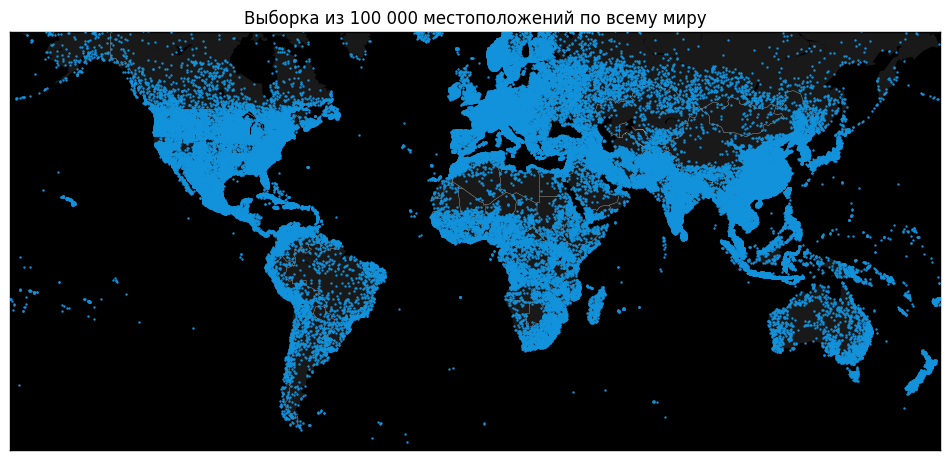

In [34]:
# Выборка случайных 100,000 записей из DataFrame
df_sample = df.sample(n=100000)

# Настройка визуализации карты
plt.figure(1, figsize=(12,6))  # Установка размера фигуры
m1 = Basemap(projection='merc', llcrnrlat=-60, urcrnrlat=65, llcrnrlon=-180, urcrnrlon=180, lat_ts=0, resolution='c')  # Создание карты с проекцией Mercator

m1.fillcontinents(color='#191919', lake_color='#000000')  # Закраска континентов и озер
m1.drawmapboundary(fill_color='#000000')  # Установка цвета границ карты
m1.drawcountries(linewidth=0.2, color="w")  # Отрисовка границ стран

# Отображение данных на карте
mxy = m1(df_sample["longitude"].tolist(), df_sample["latitude"].tolist())  # Преобразование координат для карты
m1.scatter(mxy[0], mxy[1], s=3, c="#1292db", lw=0, alpha=1, zorder=5)  # Размещение точек на карте

plt.title("Выборка из 100 000 местоположений по всему миру")  # Заголовок графика
plt.show()  # Вывод графика


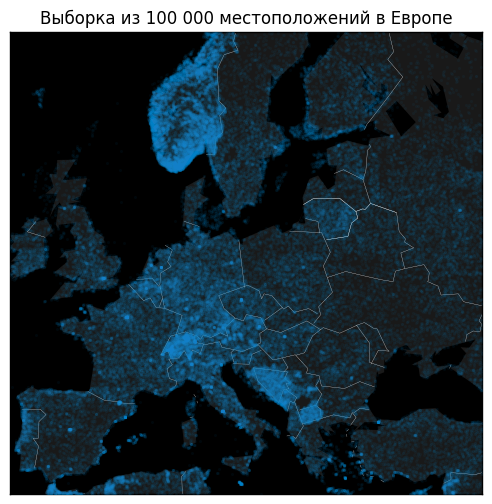

In [35]:
# Определение географических границ для Европы
lon_min, lon_max = -10, 40  # Долгота: от -10 до 40
lat_min, lat_max = 35, 65  # Широта: от 35 до 65

# Фильтрация DataFrame для получения записей внутри границ Европы
idx_europe = (df["longitude"] > lon_min) & \
            (df["longitude"] < lon_max) & \
            (df["latitude"] > lat_min) & \
            (df["latitude"] < lat_max)

# Создание нового DataFrame с выборкой из 100,000 местоположений в Европе
df_europe = df[idx_europe].sample(n=100000)

# Настройка визуализации карты Европы
plt.figure(2, figsize=(12,6))  # Установка размера фигуры
m2 = Basemap(projection='merc', llcrnrlat=lat_min, urcrnrlat=lat_max, llcrnrlon=lon_min, urcrnrlon=lon_max, lat_ts=35, resolution='c')  # Создание карты с проекцией Mercator для Европы

m2.fillcontinents(color='#191919', lake_color='#000000')  # Закраска континентов и озер
m2.drawmapboundary(fill_color='#000000')  # Установка цвета границ карты
m2.drawcountries(linewidth=0.2, color="w")  # Отрисовка границ стран

# Отображение данных на карте
mxy = m2(df_europe["longitude"].tolist(), df_europe["latitude"].tolist())  # Преобразование координат для карты
m2.scatter(mxy[0], mxy[1], s=5, c="#1292db", lw=0, alpha=0.05, zorder=5)  # Размещение точек на карте

plt.title("Выборка из 100 000 местоположений в Европе")  # Заголовок графика
plt.show()  # Вывод графика


In this case, situation is different than expected. Countries like UK, Benelux are not dense enough. Surprisingly, Norway which has very low population received big number of points. I can see that these values do not reflect the population's density then.

In [36]:
# Создание агрегированного DataFrame на основе имени и страны
Aggregated = df[['name', 'Country']]  # Выборка столбцов 'name' и 'Country' из основного DataFrame

# Группировка данных по странам и подсчет количества вхождений
Aggregated = Aggregated.groupby(['Country']).agg(['count']).sort_values([('name', 'count')], ascending=False)

# Расчет процентной доли каждой страны
Aggregated['Percentage'] = round(Aggregated[['name']] / df.shape[0], 2)  # Вычисление процента и округление до двух знаков после запятой

# Переформатирование столбцов для чистоты представления
Aggregated.columns = Aggregated.columns.get_level_values(0)  # Удаление мультиуровневости индексов столбцов
Aggregated.columns = [''.join(col).strip() for col in Aggregated.columns.values]  # Объединение и очистка названий столбцов

Aggregated  # Вывод агрегированного DataFrame


,name,Percentage
Country,,
United States of America,1774704,0.16
China,736304,0.07
India,616600,0.06
Norway,600247,0.05
Mexico,450406,0.04
...,...,...
San Marino,71,0.00
Cocos,60,0.00
Bouvet Island,47,0.00


USA, China and India or even Mexico make sense being in the top. Norway is not expected. I have an idea: let's use this data set but apply sampling to the countries based on its population. In other words, I use the given points, but I sample it by density. So for example in the above table, both China and India will grow, USA and Mexico will remain high, Norway and other small countries will drop a lot.

I merge the population data to our ISO data, it requires of course some corrections (due to differences between countries' naming).

In [31]:
# Загрузка данных о населении стран
Population = pd.read_csv('../input/population-by-country-2020/population_by_country_2020.csv')

# Переименование столбца для соответствия с другими наборами данных
Population = Population.rename(columns={"Country (or dependency)": "Country"})

# Обновление названий стран для обеспечения согласованности данных
Population[['Country']] = Population[['Country']].replace("Czech Republic (Czechia)", "Czechia")
Population[['Country']] = Population[['Country']].replace("United States", "United States of America")
Population[['Country']] = Population[['Country']].replace("United Kingdom", "United Kingdom of Great Britain and Northern Ireland")
Population[['Country']] = Population[['Country']].replace("Vietnam", "Viet Nam")
Population[['Country']] = Population[['Country']].replace("Laos", "Lao People Democratic Republic")
Population[['Country']] = Population[['Country']].replace("State of Palestine", "Palestine")
Population[['Country']] = Population[['Country']].replace("North Macedonia", "Republic of North Macedonia")
Population[['Country']] = Population[['Country']].replace("Russia", "Russian Federation")
Population[['Country']] = Population[['Country']].replace("Syria", "Syrian Arab Republic")


In [37]:
# Объединение данных о населении с ISO кодами стран
Population_Merged = pd.merge(ISO_toMerge, Population, on='Country', how='inner')

# Расчет процентной доли населения для каждой страны
Population_Merged[['Population Perc']] = Population_Merged[['Population (2020)']] / Population_Merged[['Population (2020)']].sum()

# Вывод общего процента населения, покрытого объединенными данными
print(format(round(Population_Merged[['Population (2020)']].sum() / Population[['Population (2020)']].sum(), 3)))


Population (2020)    0.976
dtype: float64


 создание взвешенной выборки из основного DataFrame, где веса определяются на основе процентной доли населения каждой страны и их представленности в данных. В результате получается выборка размером в 1,000,000 записей, в которой каждая запись имеет вероятность быть выбранной, пропорциональную размеру выборки страны, к которой она принадлежит.

In [39]:
# Установка размера выборки
Sample_Size = 1000000

# Объединение с агрегированными данными по странам
Population_Merged = pd.merge(Population_Merged, Aggregated, on='Country', how='inner')

# Расчет размера выборки для каждой страны
Population_Merged['Sample size'] = Population_Merged['Population Perc'] / Population_Merged['name'] * Population_Merged['name'].sum() * Sample_Size

# Создание нового DataFrame с данными о стране и размере выборки
Population_toMerge = Population_Merged.loc[:, Population_Merged.columns.intersection(['Country', 'Sample size'])]

# Объединение основного DataFrame с данными о размере выборки
df = pd.merge(df, Population_toMerge, on='Country', how='inner')

# Расчет общей вероятности выборки
Total_Probability = df['Sample size'].sum()

# Нормализация размеров выборки для каждой записи
df['Sample size'] = df['Sample size'] / Total_Probability

# Создание вектора вероятностей для выборки
vec = df['Sample size']

# Создание выборки с учетом весов (вероятностей) для каждой записи
df_sampled = df.sample(n=Sample_Size, weights='Sample size')


In [42]:
# Создание агрегированного DataFrame из выборки
Aggregated = df_sampled[['name', 'Country']]  # Выборка столбцов 'name' и 'Country' из выборочного DataFrame
Aggregated = Aggregated.groupby(['Country']).agg(['count']).sort_values([('name', 'count')], ascending=False)  # Группировка и подсчет количества по странам

# Добавление столбца с долей отобранных записей для каждой страны
Aggregated['Sampled records'] = round(Aggregated[['name']] / df_sampled.shape[0], 2)  # Вычисление доли и округление до двух знаков после запятой

# Переформатирование столбцов
Aggregated.columns = Aggregated.columns.get_level_values(0)  # Удаление мультиуровневости индексов столбцов
Aggregated.columns = [''.join(col).strip() for col in Aggregated.columns.values]  # Объединение и очистка названий столбцов

# Создание DataFrame для слияния, содержащего информацию о доле населения каждой страны
Population_toMerge_2 = Population_Merged.loc[:, Population_Merged.columns.intersection(['Country', 'Population Perc'])]

# Объединение агрегированных данных с информацией о доле населения
Aggregated = pd.merge(Aggregated, Population_toMerge_2, on='Country', how='inner')

Aggregated  # Вывод агрегированного DataFrame


,Country,name,Sampled records,Population Perc
0,China,182919,0.18,1.890626e-01
1,India,172326,0.17,1.814553e-01
2,United States of America,47779,0.05,4.349391e-02
3,Indonesia,38017,0.04,3.596980e-02
4,Pakistan,30192,0.03,2.909029e-02
...,...,...,...,...
206,Tuvalu,3,0.00,1.551174e-06
207,Nauru,2,0.00,1.422402e-06
208,Palau,2,0.00,2.377101e-06
209,Montserrat,1,0.00,6.554126e-07


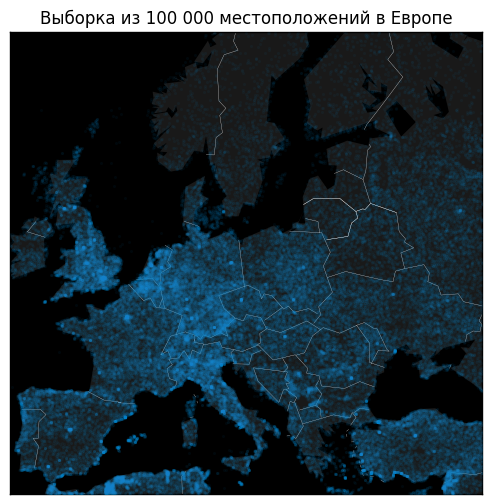

In [44]:
# Определение географических границ для Европы
lat_min, lat_max = 35, 65  # Широта: от 35 до 65

# Фильтрация DataFrame для получения записей внутри границ Европы
idx_europe = (df_sampled["longitude"] > lon_min) & \
            (df_sampled["longitude"] < lon_max) & \
            (df_sampled["latitude"] > lat_min) & \
            (df_sampled["latitude"] < lat_max)

# Создание нового DataFrame с выборкой из 100,000 местоположений в Европе
df_sampled_europe = df_sampled[idx_europe].sample(n=100000)

# Настройка визуализации карты Европы
plt.figure(2, figsize=(12,6))  # Установка размера фигуры
m2 = Basemap(projection='merc', llcrnrlat=lat_min, urcrnrlat=lat_max, llcrnrlon=lon_min, urcrnrlon=lon_max, lat_ts=35, resolution='c')  # Создание карты с проекцией Mercator для Европы

m2.fillcontinents(color='#191919', lake_color='#000000')  # Закраска континентов и озер
m2.drawmapboundary(fill_color='#000000')  # Установка цвета границ карты
m2.drawcountries(linewidth=0.2, color="w")  # Отрисовка границ стран

# Отображение данных на карте
mxy = m2(df_sampled_europe["longitude"].tolist(), df_sampled_europe["latitude"].tolist())  # Преобразование координат для карты
m2.scatter(mxy[0], mxy[1], s=5, c="#1292db", lw=0, alpha=0.05, zorder=5)  # Размещение точек на карте

plt.title("Выборка из 100 000 местоположений в Европе")  # Заголовок графика
plt.show()  # Вывод графика
